## CIFAR10 Solution

![img](https://docs.pytorch.org/tutorials/_images/cifar10.png)
> The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

Dataset [link](http://www.cs.toronto.edu/~kriz/cifar.html)

--- 

The CIFAR-10 dataset is solved using three different PyTorch approaches (barebone, Module API, and Sequential API) with convolutional neural networks for image classification across 10 object categories.

#### Import libraries

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, SubsetRandomSampler
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T
import torch.nn.functional as F
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt

In [6]:
USE_GPU = True
USE_MPS = True
dtype = torch.float32

if USE_GPU and torch.cuda.is_available():
    device = torch.device("cuda")
elif USE_MPS and torch.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Using torch.device: {device}")

Using torch.device: mps


In [7]:
NUM_TRAIN = 49_000
NUM_VAL = 1_000
batch_size = 128

In [8]:
mean_t = (0.4816, 0.4646, 0.4168)
std_t =  (0.2480, 0.2408, 0.2481)
transform = T.Compose([
    T.ToTensor(),
    T.Normalize(mean_t, std_t)
])

In [9]:
# transform = T.ToTensor()
data_dir = "./data"

train_set = datasets.CIFAR10(
    root=data_dir, train=True, download=True, transform=transform
)
val_set = datasets.CIFAR10(
    root=data_dir, train=True, download=True, transform=transform
)
test_set = datasets.CIFAR10(
    root=data_dir, train=False, download=True, transform=transform
)

In [ ]:
##  Normalized Transformer + calculate mean, stg

# loader_whole_train = DataLoader(train_set, batch_size=batch_size)

# imgs, _ = next(iter(loader_whole_train)) #shape(N, 3, H, W)
# print(imgs.shape)

# mean = imgs.mean(dim=[0,2,3])

# std = imgs.std(dim=[0,2,3])
# print(f"Mean value: {mean}")
# print(f"Std value: {std}")

## Manually insert vallues and can be reused in previous step

# transform = T.Compose([
#     T.ToTensor(),
#     T.Normalize(0.4816, 0.4646, 0.4168), (0.2480, 0.2408, 0.2481))
# ])


torch.Size([64, 3, 32, 32])
Mean value: tensor([0.4816, 0.4646, 0.4168])
Std value: tensor([0.2480, 0.2408, 0.2481])


In [10]:
__USE_PIN_MEMORY = USE_GPU * (not USE_MPS)
loader_train = DataLoader(
    train_set, 
    batch_size=batch_size,
    sampler=SubsetRandomSampler(range(NUM_TRAIN)),
    num_workers=2,
    pin_memory=__USE_PIN_MEMORY,
)
loader_val = DataLoader(
    val_set,
    batch_size=batch_size,
    sampler=SubsetRandomSampler(range(NUM_TRAIN, NUM_TRAIN + NUM_VAL)),
    num_workers=2,
    pin_memory=__USE_PIN_MEMORY,
)
loader_test = DataLoader(
    test_set,
    batch_size=batch_size,
    num_workers=2,
    pin_memory=__USE_PIN_MEMORY,
)

### Data exploration

#### Explore dataset stats

In [11]:
from collections import Counter


print(f"Train set size: {len(train_set)}")
print(f"Validation set size: {len(val_set)}")
print(f"Test set size: {len(test_set)}")
print()

classes = train_set.classes
print(f"Num of classes: {len(classes)}")
print(f"Classes: {classes}")
labels_counter = Counter([i[1] for i in train_set])
for i, label in enumerate(classes):
    print(f"{label:10} - {labels_counter[i]} images")
print()

xb, yb = next(iter(loader_train))
print(f"Batch shape: {xb.shape}")
print(f"One image shape: {xb[0].shape}")
print()


Train set size: 50000
Validation set size: 50000
Test set size: 10000

Num of classes: 10
Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
airplane   - 5000 images
automobile - 5000 images
bird       - 5000 images
cat        - 5000 images
deer       - 5000 images
dog        - 5000 images
frog       - 5000 images
horse      - 5000 images
ship       - 5000 images
truck      - 5000 images

Batch shape: torch.Size([128, 3, 32, 32])
One image shape: torch.Size([3, 32, 32])



#### Show first class images

[3, 6, 25, 0, 22, 12, 4, 13, 1, 11]


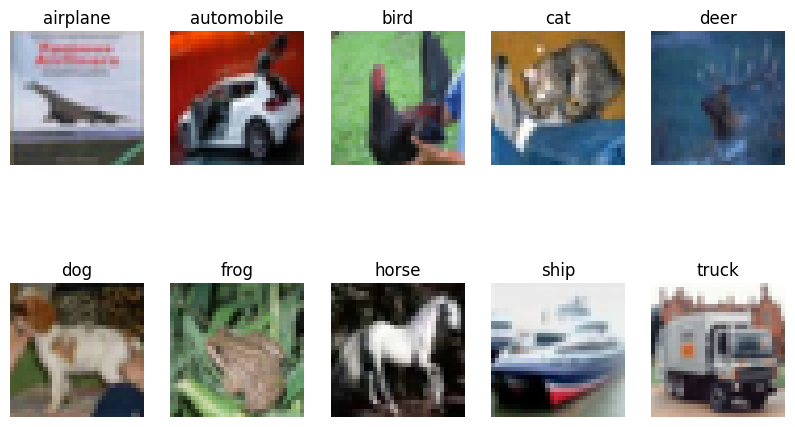

In [12]:
mean = torch.tensor(mean_t).view(3,1,1)
std = torch.tensor(std_t).view(3,1,1)

examples = [None] * len(classes)
for i, (x,y) in enumerate(test_set):
    if (examples[y] is None):
        examples[y] = i
    if all((e is not None for e in examples)):
        break
print(examples)

fig, axs = plt.subplots(*(2, 5), figsize=(10,6))
for i, ax in enumerate(axs.flatten()):
    index = examples[i]
    x, y = test_set[index]
    x_disp = (x * std + mean).clamp(0, 1)
    ax.imshow(x_disp.permute(1,2,0).cpu().numpy())
    ax.set_title(classes[i])
    ax.axis("off")
plt.show()

## KNN

In [18]:
def knn_predict(train_x, train_y, xq, k=5):
    a2 = (xq**2).sum(1, keepdim=True)
    b2 = (train_x**2).sum(1, keepdim=True).T
    d2 = a2 + b2 - 2 * xq@train_x.T
    
    idx = torch.topk(-d2, k=k, dim=1).indices
    neigh = train_y[idx]
    
    preds = torch.mode(neigh, dim=1).values
    return preds

In [19]:

def build_matrix(dloader, limit=1000):
    xs, ys = [], []
    for x, y in dloader:
        x = x.view(x.size(0), -1)
        xs.append(x.cpu())
        ys.append(y.cpu())
        if sum([len(a) for a in xs]) >= limit: break

    X = torch.cat(xs, 0)[:limit].float()
    Y = torch.cat(ys, 0)[:limit].float()

    return X, Y

In [20]:
Xtr, Ytr = build_matrix(loader_test, limit=2000)
Xva, Yva = build_matrix(loader_val, limit=500)

In [21]:
preds = knn_predict(Xtr, Ytr, Xva, k=5)

acc = (preds==Yva).float().mean().item()

print(f"{acc*100:.2f}")

25.00


## Linear Classifier

In [22]:
Xtr_np = Xtr.cpu().numpy() if hasattr(Xtr, "cpu") else Xtr
Ytr_np = Ytr.cpu().numpy() if hasattr(Ytr, "cpu") else Ytr

In [23]:
Ndemo = 256
Xd = Xtr_np[:Ndemo].astype(np.float32, copy=False)
Yd = Ytr_np[:Ndemo].astype(np.int64, copy=False)

print(f"Xd shape: {Xd.shape}")
print(f"Yd shape: {Yd.shape}") 

Xd shape: (256, 3072)
Yd shape: (256,)


In [24]:
D = Xd.shape[1]
C = len(classes)

In [25]:
rng = np.random.RandomState(0)
w = 0.001 * rng.randn(D, C).astype(np.float32)
reg = 1e-4

# forward
scores = Xd.dot(w)

scores -= scores.max(axis=1, keepdims=True)
exp = np.exp(scores)
probs = exp / np.sum(exp, axis=1, keepdims=True)

In [26]:
loss_data = -np.log(probs[np.arange(Ndemo), Yd]).mean()
loss_reg = 0.5 * reg * np.sum(w*w)
loss = loss_data + loss_reg

print(f"Softmax loss: {loss:.4f}")

Softmax loss: 2.3136


In [27]:
dscores = probs
dscores [np. arange (Ndemo), Yd] - 1
dscores /= Ndemo
dW = Xd.T.dot (dscores) + reg*w

In [28]:
print("W shape:,", w.shape)

W shape:, (3072, 10)


In [29]:
lr = 1e-0
w -= lr*dW

In [30]:
scores = Xd.dot(w) # logits for all samples
preds = scores.argmax(axis=1) #predicted class per sample
acc = (preds == Yd).mean() # mean of correct predictions
print(f"Accuracy after one update: {acc*100:.2f}%")

Accuracy after one update: 13.28%


In [31]:
x_new = Xd [0:1] # shape(1, D)
logits = x_new.dot (w) # (1, C)
pred = logits.argmax(axis=1) # scalar class id
print("Predicted class for first sample: ", pred. item())

Predicted class for first sample:  6


#### Pytorch

In [36]:
class LinearSoftMax(nn.Module):
    def __init__(self, D, C):
        super().__init__()

        self.fc = nn.Linear(D,C)
        nn.init.kaiming_normal_(self.fc.weight)
        nn.init.zeros_(self.fc.bias)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.fc(x)

def train_epoch(model, loader, opt, loss_fn):
    model.train()
    losses, correct, total = [], 0, 0

    for x,y in loader:
        x, y = x.to(device), y.to(device)
        
        opt.zero_grad()
        scores = model(x)
        loss = loss_fn(scores, y)

        loss.backward()
        opt.step()
        losses += [loss.item()]
        pred = scores.argmax(1)
        correct += (pred==y).sum().item()
        total += y.size(0)
    return np.mean(losses), correct/total


In [40]:
@torch.no_grad()
def eval_model(model, loader, loss_fn):
    model.eval()
    losses, correct, total = [], 0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)

        scores = model(x)
        loss = loss_fn(scores, y)

        losses += [loss.item()]
        pred = scores.argmax(1)
        correct += (pred==y).sum().item()
        total += y.size(0)
    return np.mean(losses), correct/total


In [37]:
model = LinearSoftMax(D, C).to(device)
opt = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
loss_fn = nn.CrossEntropyLoss()

In [42]:
for ep in range(3):
    tr_loss, tr_acc = train_epoch(model,loader_train, opt, loss_fn)
    va_loss, va_acc = eval_model(model, loader_val, loss_fn)
    print(f"ep: {ep+1}/3, train (loss, acc): {tr_loss}, {tr_acc} | validation (loss, acc): {va_loss}, {va_acc}")

ep: 1/3, train (loss, acc): 18.691108688673214, 0.29336734693877553 | validation (loss, acc): 17.03781545162201, 0.282
ep: 2/3, train (loss, acc): 18.984042605905557, 0.29436734693877553 | validation (loss, acc): 16.928399085998535, 0.265
ep: 3/3, train (loss, acc): 17.736948222466612, 0.29889795918367346 | validation (loss, acc): 24.57183527946472, 0.29


In [45]:
tst_loss, tst_acc = eval_model(model, loader_test, loss_fn)
print(f"Final test (loss, accuracy): {tst_loss}, {tst_acc*100:.2f}%")

Final test (loss, accuracy): 24.89730460734307, 28.41%


## Barebone PyTorch Approach (CNN)

In [64]:
def flatten(x):
    N = x.shape[0]  # [N, C, H, W] -> [N, C * H * W]
    return x.view(N, -1)


def test_flatten():
    x = torch.arange(12).view(2, 1, 3, 2)
    print(x)
    print(flatten(x))


test_flatten()

tensor([[[[ 0,  1],
          [ 2,  3],
          [ 4,  5]]],


        [[[ 6,  7],
          [ 8,  9],
          [10, 11]]]])
tensor([[ 0,  1,  2,  3,  4,  5],
        [ 6,  7,  8,  9, 10, 11]])


In [65]:
def three_layer_convnet(x, params):
    conv_w1, conv_b1, conv_w2, conv_b2, fc_w, fc_b = params
    scores = None

    # Forward pass for 3-layer convnet
    x = F.relu(F.conv2d(x, conv_w1, conv_b1, padding=2))
    x = F.relu(F.conv2d(x, conv_w2, conv_b2, padding=3))

    scores = flatten(x).mm(fc_w) + fc_b
    return scores

In [66]:
def three_layer_convnet_test():
    x = torch.zeros((64, 3, 32, 32), dtype=dtype)

    # out_channel, in_channel, kernel_H, kernel_W
    conv_w1 = torch.zeros((6, 3, 5, 5), dtype=dtype)
    conv_b1 = torch.zeros((6,), dtype=dtype)  # out_channel\

    conv_w2 = torch.zeros((9, 6, 7, 7), dtype=dtype)
    conv_b2 = torch.zeros((9,), dtype=dtype)

    fc_w = torch.zeros((9 * 32 * 32, 10))
    fc_b = torch.zeros((10))

    scores = three_layer_convnet(x, (conv_w1, conv_b1, conv_w2, conv_b2, fc_w, fc_b))
    print(scores.size())


three_layer_convnet_test()

torch.Size([64, 10])


In [67]:
def random_weight(shape):
    if len(shape) == 2:
        fan_in = shape[0]
    else:
        fan_in = np.prod(shape[1:])  # Conv weight [out_chan, in_chan, kH, kW]

    w = torch.randn(shape, device=device, dtype=dtype)
    w = w * np.sqrt(2.0 / fan_in)
    w.requires_grad_(True)

    return w


def zero_weight(shape):
    torch.zeros(shape, device=device, dtype=dtype, requires_grad=True)


random_weight((3, 5))

tensor([[-0.0862,  1.3392, -0.7153,  0.8380, -0.6382],
        [ 0.2291, -1.1612, -1.4404,  1.2302,  0.0703],
        [-2.7175,  0.2669, -0.2979,  1.9289,  1.5645]], device='mps:0',
       requires_grad=True)

In [68]:
def check_accuracy(loader, model_fn, params):
    split = "val" if loader.dataset.train else "test"
    print(f"Checking accuracy on the, {split} set")

    num_correct, num_samples = 0, 0

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)
            y = y.to(device=device, dtype=torch.int64)

            scores = model_fn(x, params)
            _, preds = scores.max(1)

            num_correct += (preds == y).sum()
            num_samples += preds.size(0)

    acc = float(num_correct) / num_samples
    print("Got %d / %d correct (%.2f%%)" % (num_correct, num_samples, 100 * acc))

In [69]:
def train_fn(model_fn, params, learing_rate, *, epochs=2, print_every=10):
    for epoch in range(1, epochs + 1):
        print(f"Epoch {epoch}/{epochs}")
        for t, (x, y) in enumerate(loader_train):
            x = x.to(device=device, dtype=dtype)
            y = y.to(device=device, dtype=torch.int64)

            # Forward pass
            scores = model_fn(x, params)
            loss = F.cross_entropy(scores, y)

            # Backward pass
            loss.backward()

            with torch.no_grad():
                for w in params:
                    w -= learing_rate * w.grad
                    w.grad.zero_()

            if t % print_every == 0:
                print(f"Ireration: {t} loss: {loss.item()}")
                check_accuracy(loader_val, model_fn, params)
                print()

In [70]:
learning_rate = 3e-3

channel_1 = 16
channel_2 = 32

conv_w1 = random_weight((channel_1, 3, 5, 5))
conv_b1 = random_weight((channel_1,))

conv_w2 = random_weight((channel_2, channel_1, 7, 7))
conv_b2 = random_weight((channel_2,))

fc_w = random_weight((channel_2 * 32 * 32, 10))
fc_b = random_weight((10,))


params = (conv_w1, conv_b1, conv_w2, conv_b2, fc_w, fc_b)

train_fn(three_layer_convnet, params, learning_rate)
check_accuracy(loader_test, three_layer_convnet, params)

Epoch 1/2
Ireration: 0 loss: 4.620083808898926
Checking accuracy on the, val set
Got 81 / 1000 correct (8.10%)

Ireration: 10 loss: 2.3530941009521484
Checking accuracy on the, val set
Got 132 / 1000 correct (13.20%)

Ireration: 20 loss: 2.309741497039795
Checking accuracy on the, val set
Got 116 / 1000 correct (11.60%)

Ireration: 30 loss: 2.2887091636657715
Checking accuracy on the, val set
Got 180 / 1000 correct (18.00%)

Ireration: 40 loss: 2.272648334503174
Checking accuracy on the, val set
Got 182 / 1000 correct (18.20%)

Ireration: 50 loss: 2.187894821166992
Checking accuracy on the, val set
Got 177 / 1000 correct (17.70%)

Ireration: 60 loss: 2.2128167152404785
Checking accuracy on the, val set
Got 203 / 1000 correct (20.30%)

Ireration: 70 loss: 2.1692466735839844
Checking accuracy on the, val set
Got 229 / 1000 correct (22.90%)

Ireration: 80 loss: 2.1284427642822266
Checking accuracy on the, val set
Got 239 / 1000 correct (23.90%)

Ireration: 90 loss: 2.059196710586548
Check

In [71]:
def check_accuracy_v2(loader, model):
    split = "val" if loader.dataset.train else "test"
    print(f"Checking accuracy on the, {split} set")

    num_correct = 0
    num_samples = 0

    model.eval()  # set model to evaluation mode

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)
            y = y.to(device=device, dtype=torch.int64)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)

        acc = float(num_correct) / num_samples
        print("Got %d / %d correct (%.2f%%)" % (num_correct, num_samples, 100 * acc))

In [72]:
def train_fn_v2(model, optimizer, *, epochs=2, print_every=10):
    model = model.to(device=device)

    for e in range(epochs):
        for t, (x, y) in enumerate(loader_train):
            model.train()  # putting model to training mode
            x = x.to(device=device, dtype=dtype)
            y = y.to(device=device, dtype=torch.int64)

            scores = model(x)
            loss = F.cross_entropy(scores, y)

            optimizer.zero_grad()

            loss.backward()

            optimizer.step()

            if t % print_every == 0:
                print("Iteration %d, loss = %.4f" % (t, loss.item()))
                check_accuracy_v2(loader_val, model)
                print()

## Module API Pytorch Approach

In [73]:
class ThreeLayerConvNet(nn.Module):
    def __init__(self, in_channel, channel_1, channel_2, num_classes):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channel, channel_1, 5, padding=2)
        nn.init.kaiming_normal_(self.conv1.weight)
        self.conv2 = nn.Conv2d(channel_1, channel_2, 7, padding=3)
        nn.init.kaiming_normal_(self.conv2.weight)
        self.fc = nn.Linear(channel_2 * 32 * 32, num_classes)
        nn.init.kaiming_normal_(self.fc.weight)

    def forward(self, x):
        scores = None

        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        scores = self.fc(flatten(x))

        return scores


def test_ThreeLaterConvNet():
    x = torch.zeros((64, 3, 32, 32), dtype=dtype)
    model = ThreeLayerConvNet(in_channel=3, channel_1=12, channel_2=32, num_classes=10)
    scores = model(x)
    print(scores.size())


test_ThreeLaterConvNet()

torch.Size([64, 10])


In [74]:
learning_rate = 3e-3
channel_1 = 16
channel_2 = 32

model = None
optimizer = None

model = ThreeLayerConvNet(3, channel_1, channel_2, 10)
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

train_fn_v2(model, optimizer)

Iteration 0, loss = 2.4130
Checking accuracy on the, val set
Got 105 / 1000 correct (10.50%)

Iteration 10, loss = 2.2809
Checking accuracy on the, val set
Got 191 / 1000 correct (19.10%)

Iteration 20, loss = 2.1173
Checking accuracy on the, val set
Got 151 / 1000 correct (15.10%)

Iteration 30, loss = 2.1587
Checking accuracy on the, val set
Got 260 / 1000 correct (26.00%)

Iteration 40, loss = 1.9512
Checking accuracy on the, val set
Got 240 / 1000 correct (24.00%)

Iteration 50, loss = 2.0022
Checking accuracy on the, val set
Got 257 / 1000 correct (25.70%)

Iteration 60, loss = 2.0800
Checking accuracy on the, val set
Got 277 / 1000 correct (27.70%)

Iteration 70, loss = 2.0790
Checking accuracy on the, val set
Got 277 / 1000 correct (27.70%)

Iteration 80, loss = 1.8662
Checking accuracy on the, val set
Got 256 / 1000 correct (25.60%)

Iteration 90, loss = 2.0134
Checking accuracy on the, val set
Got 264 / 1000 correct (26.40%)

Iteration 100, loss = 1.9267
Checking accuracy on t

In [75]:
check_accuracy_v2(loader_test, model)

Checking accuracy on the, test set
Got 4756 / 10000 correct (47.56%)


## Sequential API PyTorch Aproach


In [76]:
class Flatten(nn.Module):
    def forward(self, x):
        return flatten(x)

In [77]:
channel_1 = 16
channel_2 = 32
learning_rate = 1e-2

model = None
optimizer = None

model = nn.Sequential(
    nn.Conv2d(3, channel_1, 5, padding=2),
    nn.ReLU(),
    nn.Conv2d(channel_1, channel_2, 7, padding=3),
    nn.ReLU(),
    Flatten(),
    nn.Linear(channel_2 * 32 * 32, 10),
)

optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, nesterov=True)

train_fn_v2(model, optimizer)

Iteration 0, loss = 2.2995
Checking accuracy on the, val set
Got 108 / 1000 correct (10.80%)

Iteration 10, loss = 2.2494
Checking accuracy on the, val set
Got 104 / 1000 correct (10.40%)

Iteration 20, loss = 2.1408
Checking accuracy on the, val set
Got 242 / 1000 correct (24.20%)

Iteration 30, loss = 2.1855
Checking accuracy on the, val set
Got 195 / 1000 correct (19.50%)

Iteration 40, loss = 2.2497
Checking accuracy on the, val set
Got 175 / 1000 correct (17.50%)

Iteration 50, loss = 2.1484
Checking accuracy on the, val set
Got 193 / 1000 correct (19.30%)

Iteration 60, loss = 1.9519
Checking accuracy on the, val set
Got 290 / 1000 correct (29.00%)

Iteration 70, loss = 1.9899
Checking accuracy on the, val set
Got 275 / 1000 correct (27.50%)

Iteration 80, loss = 2.4651
Checking accuracy on the, val set
Got 192 / 1000 correct (19.20%)

Iteration 90, loss = 2.1894
Checking accuracy on the, val set
Got 243 / 1000 correct (24.30%)

Iteration 100, loss = 2.0831
Checking accuracy on t

In [78]:
check_accuracy_v2(loader_test, model)

Checking accuracy on the, test set


Got 5817 / 10000 correct (58.17%)
